[Automatic variational ABC](https://arxiv.org/abs/1606.08549) for exoplanets?

In [2]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["savefig.dpi"] = 300
rcParams["figure.dpi"] = 300

In [16]:
from autograd import grad
import autograd.numpy as np
from autograd.scipy.misc import logsumexp
from autograd.optimizers import adam

import matplotlib.pyplot as plt

In [4]:
def completeness(x, y):
    snr = y**2 * np.sqrt(2000.0 / x) * 1e3
    return 1.0 / (1 + np.exp(-0.3 * (snr - 10.0)))

def power_law(u, n, mn, mx):
    np1 = n+1.0
    if np.allclose(np1, 0.0):
        return mn * np.exp(u * (np.log(mx) - np.log(mn)))
    x0n = mn ** np1
    return ((mx**np1 - x0n) * u + x0n) ** (1.0 / np1)

In [5]:
N_tot = 1000
K = np.random.poisson(0.5 * N_tot)
XY_true = np.vstack((
    10**np.random.uniform(0, 2, K),
    power_law(np.random.rand(K), -1.5, 0.01, 0.1),
)).T
Q = completeness(XY_true[:, 0], XY_true[:, 1])
XY_obs = np.array(XY_true[Q > np.random.rand(K)])

In [91]:
class Simulator(object):
    
    def __init__(self, XY, N_tot, x_range, y_range,
                 mu_lg, sig_lg, mu_nx, sig_nx, mu_ny, sig_ny):
        self.N_tot = N_tot
        self.x_range = x_range
        self.y_range = y_range
        self.stats_obs = self.stats(XY[:, 0], XY[:, 1])
        
        # Prior
        self.priors = [(mu_lg, sig_lg), (mu_nx, sig_nx), (mu_ny, sig_ny)]
        
    def kld(self, phi):
        kld = 0.0
        for (mu1, lsig1), (mu2, sig2) in zip((phi[:2], phi[2:4], phi[4:6]), self.priors):
            sig1 = np.exp(lsig1)
            kld += np.log(sig2/sig1)+0.5*((sig1**2+(mu1-mu2)**2)/sig2**2-1.0)
        return kld
    
    def stats(self, x, y):
        x, y = np.log(x), np.log(y)
        return np.array([10*np.log(len(x)), np.mean(x), np.log(np.var(x)), np.mean(y), np.log(np.var(y))])
        
    def _f(self, theta, u_exist, u_det, u_x, u_y):
        q = u_exist < np.exp(theta[0])
        x = power_law(u_x[q], theta[1], *(self.x_range))
        y = power_law(u_y[q], theta[2], *(self.y_range))
        q_det = completeness(x, y) > u_det[q]
        return x[q_det], y[q_det]
    
    def _g(self, phi, nu):
        return np.array([
            phi[0] + np.exp(phi[1]) * nu[0],
            phi[2] + np.exp(phi[3]) * nu[1],
            phi[4] + np.exp(phi[5]) * nu[2],
        ])
    
    def simulate(self, theta):
        return self._f(theta, *(np.random.rand(4, self.N_tot)))
    
    def sample(self, phi):
        theta = self._g(phi, np.random.randn(3))
        return self.simulate(theta)
    
    def _log_p_eps(self, phi, nu, u, eps=0.1):
        theta = self._g(phi, nu)
        sim = self._f(theta, *u)
        if len(sim[0]) < 2:
            return -np.inf
        stats = self.stats(*sim)
        return -0.5 * np.sum((stats - self.stats_obs)**2 / eps**2 + np.log(2*np.pi*eps**2))

    def elbo_abc(self, phi, iteration, S=10, L=8):
        print(iteration)
        nu = np.random.randn(S, 3)
        u = np.random.rand(L, 4, self.N_tot)
        lp = 0.0
        for s in range(S):
            lp += logsumexp(np.array([self._log_p_eps(phi, nu[s], u[l]) for l in range(L)]))
        lp /= S
        elbo = lp - np.log(L) - self.kld(phi)
        print(elbo)
        return -elbo

In [92]:
sim = Simulator(XY_obs, N_tot, (1.0, 100.0), (0.01, 0.1),
                -1.0, 5.0, 0.0, 3.0, 0.0, 3.0)

In [93]:
objective_grad = grad(sim.elbo_abc)
init_params = np.array([np.log(0.5), np.log(0.001), -1.0, np.log(1.0), -1.5, np.log(1.0)])

In [94]:
batch_size = 256
num_epochs = 5
step_size = 0.01
optimized_params = adam(objective_grad, init_params, step_size=step_size,
                        num_iters=500)  #, callback=print_perf)

0
Autograd ArrayNode with value -484.785065766 and 1 progenitors(s)
1
Autograd ArrayNode with value -332.19258367 and 1 progenitors(s)
2
Autograd ArrayNode with value -445.696507271 and 1 progenitors(s)
3
Autograd ArrayNode with value -498.945525558 and 1 progenitors(s)
4
Autograd ArrayNode with value -591.982020646 and 1 progenitors(s)
5
Autograd ArrayNode with value -145.160823625 and 1 progenitors(s)
6
Autograd ArrayNode with value -564.800550698 and 1 progenitors(s)
7
Autograd ArrayNode with value -630.945991965 and 1 progenitors(s)
8
Autograd ArrayNode with value -683.652710857 and 1 progenitors(s)
9
Autograd ArrayNode with value -335.401790484 and 1 progenitors(s)
10
Autograd ArrayNode with value -437.758785053 and 1 progenitors(s)
11
Autograd ArrayNode with value -1074.86759945 and 1 progenitors(s)
12
Autograd ArrayNode with value -336.889716344 and 1 progenitors(s)
13
Autograd ArrayNode with value -526.24718382 and 1 progenitors(s)
14
Autograd ArrayNode with value -342.95056870

In [95]:
optimized_params[::2], np.exp(optimized_params[1::2])

(array([-1.        , -1.0358322 , -1.65847923]),
 array([ 0.14836694,  0.15359537,  0.27360592]))

In [96]:
init_params

array([-0.69314718, -6.90775528, -1.5       ,  0.        , -1.        ,  0.        ])

In [97]:
x, y = sim.sample(optimized_params)

In [98]:
sim.stats(x, y)

array([ 53.08267697,   2.28190208,   0.45620768,  -3.09571888,  -1.23669038])

In [99]:
sim.stats_obs

array([ 56.97093487,   1.82518364,   0.47677183,  -3.27630407,  -1.1595003 ])

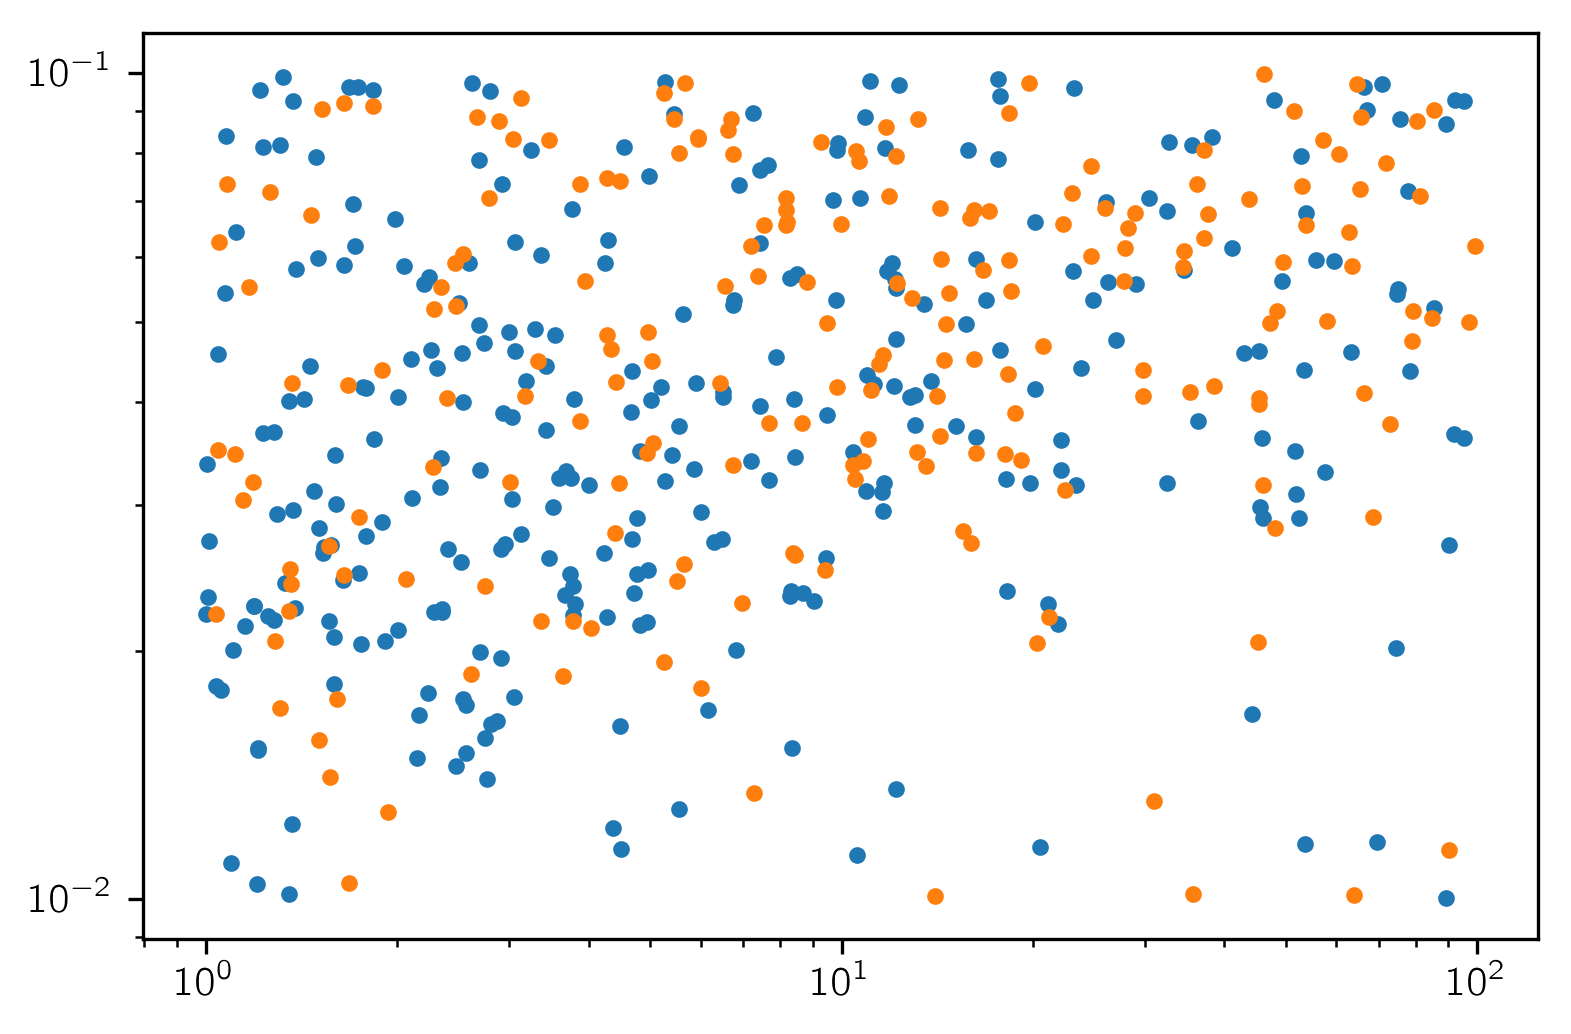

In [100]:
plt.plot(XY_obs[:, 0], XY_obs[:, 1], ".")
plt.plot(x, y, ".")
plt.xscale("log")
plt.yscale("log")

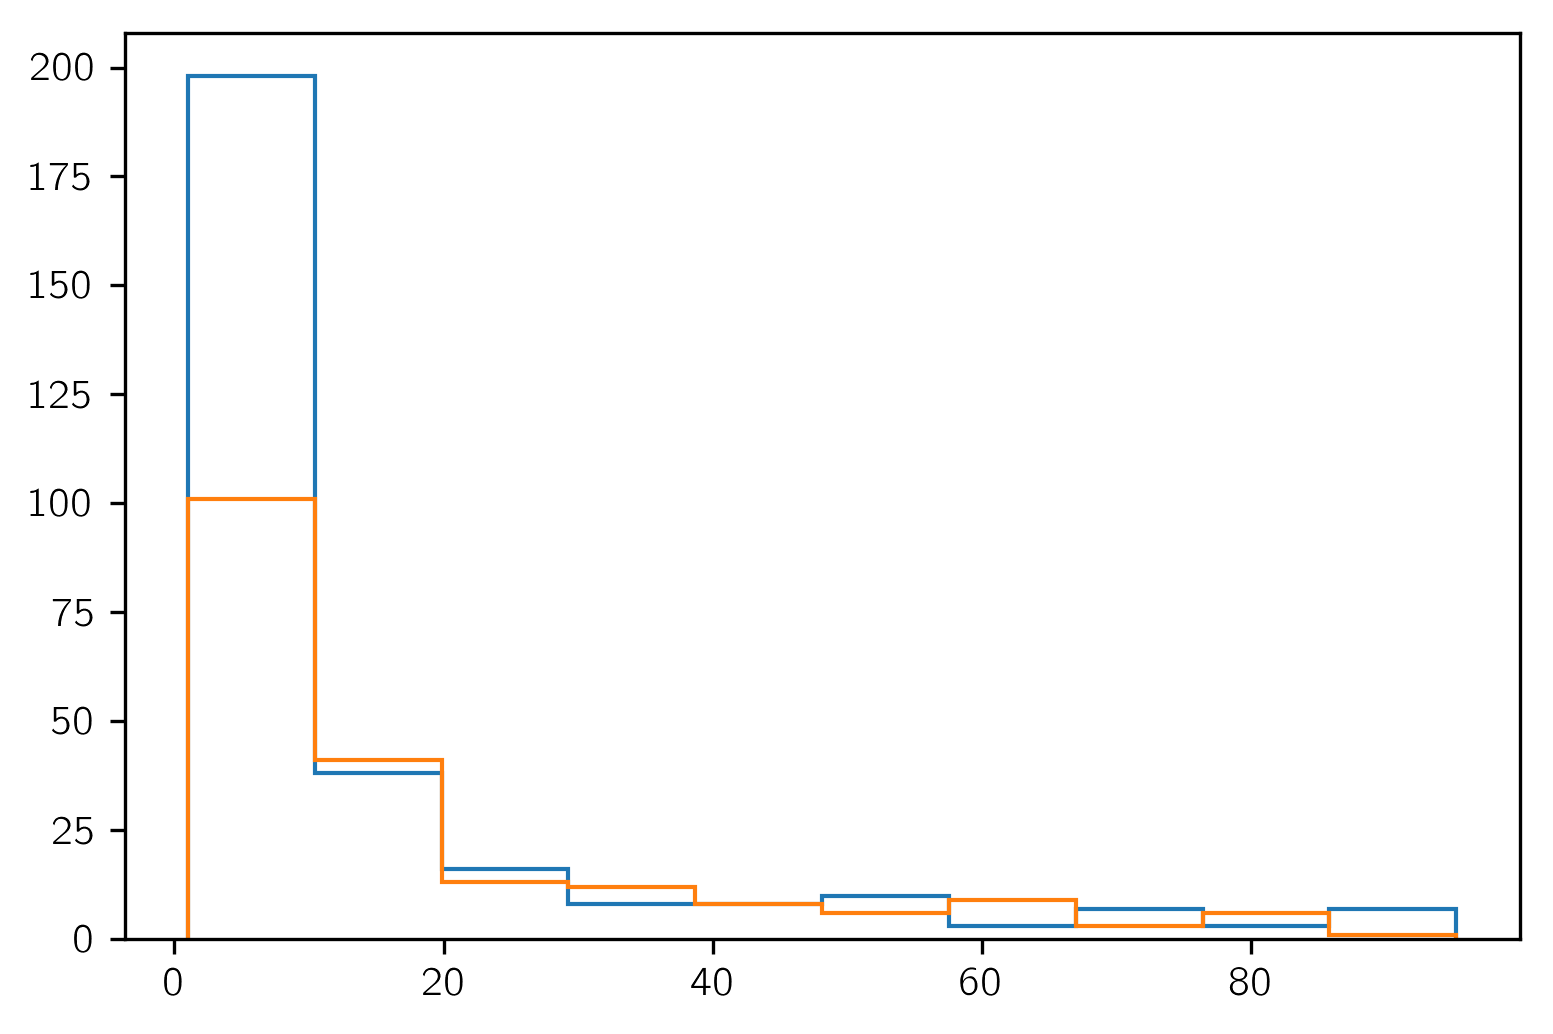

In [101]:
_, bins, _ = plt.hist(XY_obs[:, 0], histtype="step")
plt.hist(x, bins, histtype="step");

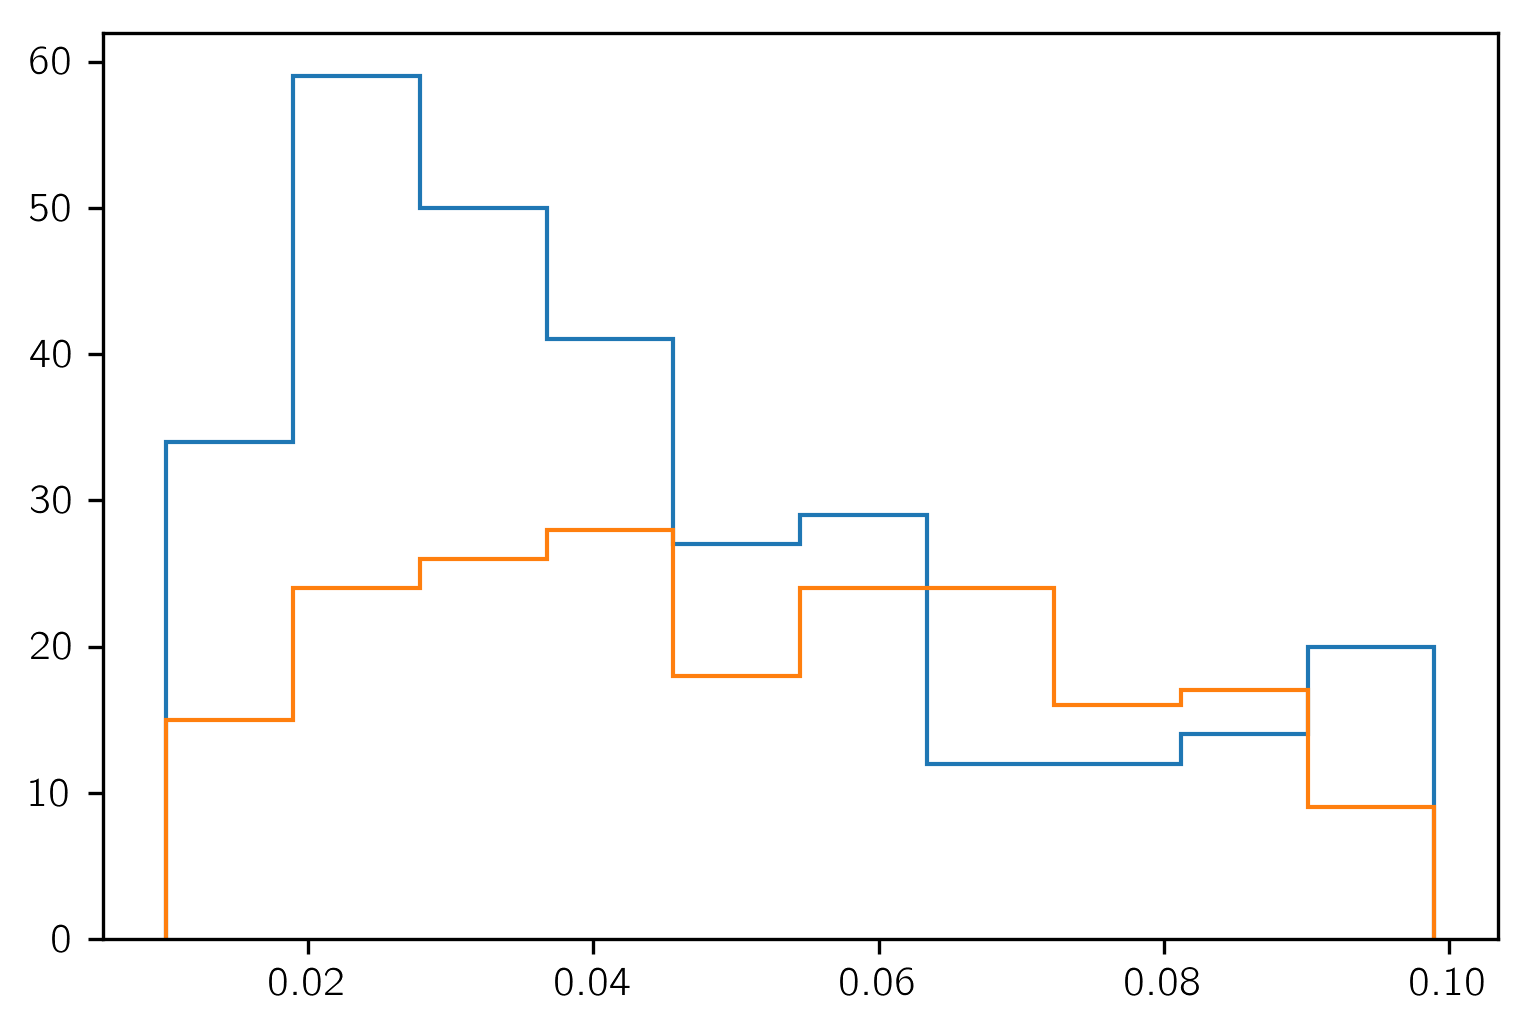

In [102]:
_, bins, _ = plt.hist(XY_obs[:, 1], histtype="step")
plt.hist(y, bins, histtype="step");